### Importação das bibliotecas

Importamos as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import shap
from lime.lime_tabular import LimeTabularExplainer


1. Carregamento do dataset e separação entre variáveis independentes e alvo.

In [2]:
df = pd.read_csv("ocorrencias_aereas_tratadas.csv", encoding='utf-8')

X = df.drop(columns=[
    'codigo_ocorrencia', 'ocorrencia_classificacao',
    'outlier_ocorrencia_longitude','outlier_ocorrencia_latitude',
    'outlier_aeronave_pmd','outlier_aeronave_assentos',
    'cluster'
])
y = df['ocorrencia_classificacao']


2. Identificando tipos de colunas

In [3]:
colunas_numericas = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
colunas_categoricas = X.select_dtypes(include='object').columns.tolist()

print(f"Colunas numéricas: {colunas_numericas}")
print(f"Colunas categóricas: {colunas_categoricas}")

Colunas numéricas: ['ocorrencia_latitude', 'ocorrencia_longitude', 'aeronave_pmd', 'aeronave_assentos', 'aeronave_ano_fabricacao', 'ocorrencia_ano', 'aeronave_idade']
Colunas categóricas: ['ocorrencia_cidade', 'ocorrencia_uf', 'ocorrencia_pais', 'ocorrencia_aerodromo', 'ocorrencia_dia', 'ocorrencia_hora', 'aeronave_matricula', 'aeronave_operador_categoria', 'aeronave_tipo_veiculo', 'aeronave_fabricante', 'aeronave_modelo', 'aeronave_tipo_icao', 'aeronave_motor_tipo', 'aeronave_motor_quantidade', 'aeronave_pmd_categoria', 'aeronave_pais_fabricante', 'aeronave_pais_registro', 'aeronave_registro_categoria', 'aeronave_registro_segmento', 'aeronave_voo_origem', 'aeronave_voo_destino', 'aeronave_tipo_operacao', 'outlier_aeronave_ano_fabricacao']


3. Definindo transformador

In [4]:
preprocessador = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), colunas_categoricas)
], remainder='passthrough', verbose_feature_names_out=False, force_int_remainder_cols=False)  # Mantém numéricas como estão

4. Criando o pipeline com Random Forest e SMOTE

In [5]:
pipeline = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('smote', SMOTE(k_neighbors=1,random_state=42)),
    ('classificador', RandomForestClassifier(max_depth=15, min_samples_leaf=5, random_state=42))
])

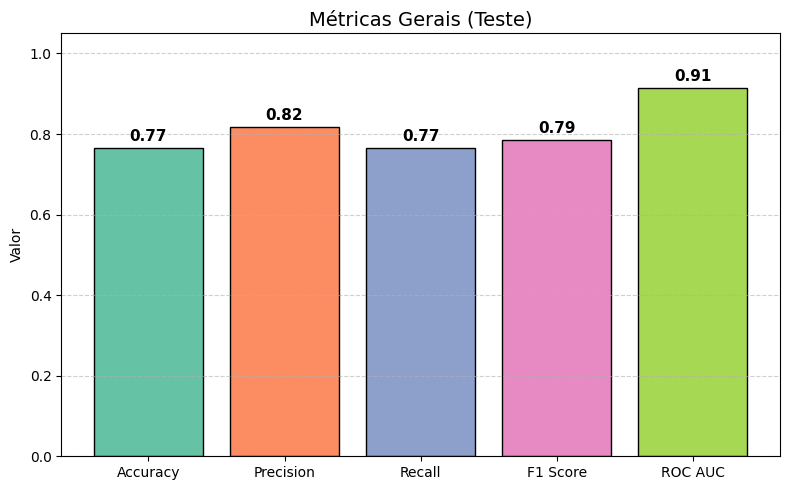

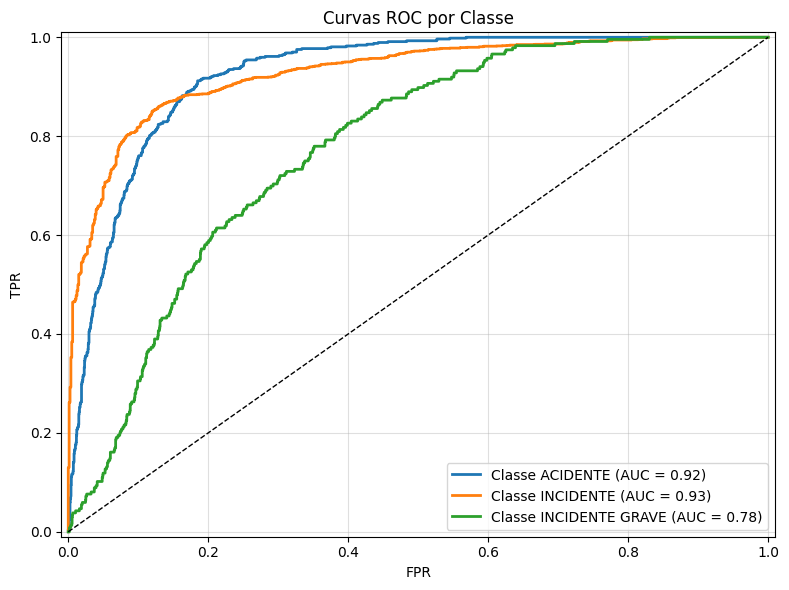


=== CROSS VALIDATION (5-fold) ===


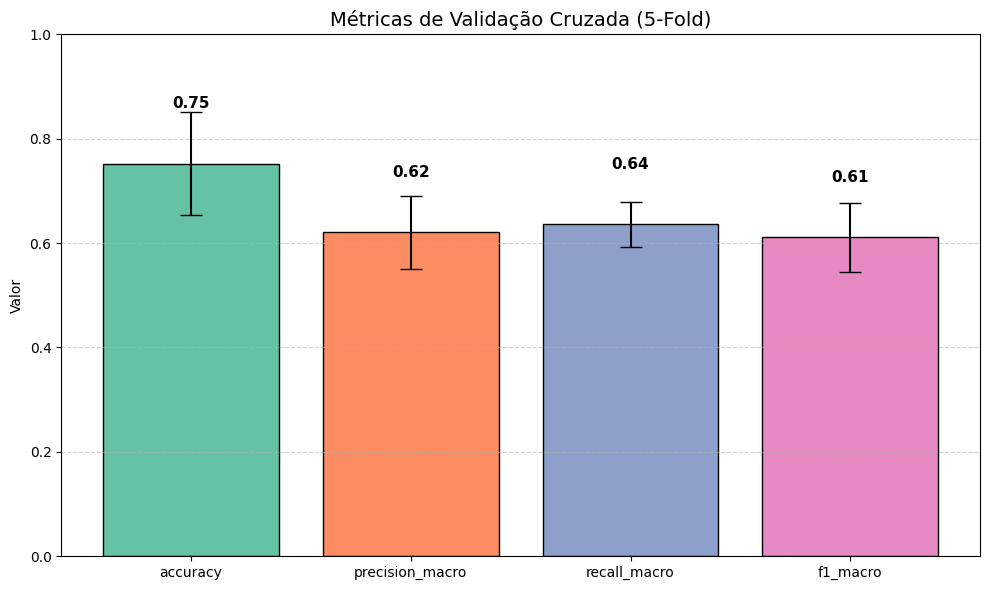

In [6]:
# 5. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 6. Treinar modelo
pipeline.fit(X_train, y_train)
# Previsões
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

# Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Binariza as classes para cálculo da curva ROC AUC
classes = pipeline.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_proba_bin = y_proba

# Calcular ROC AUC
try:
    roc_auc = roc_auc_score(y_test_bin, y_proba_bin, average='weighted', multi_class='ovr')
except:
    roc_auc = None

# ==== GRÁFICO DAS MÉTRICAS GERAIS ====
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score'] + (['ROC AUC'] if roc_auc is not None else [])
metric_values = [acc, prec, rec, f1] + ([roc_auc] if roc_auc is not None else [])
colors = sns.color_palette('Set2', n_colors=len(metric_values))

plt.figure(figsize=(8, 5))
bars = plt.bar(metric_labels, metric_values, color=colors, edgecolor='black')

# Adiciona os valores nas barras
for bar, value in zip(bars, metric_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylim(0, 1.05)
plt.ylabel("Valor")
plt.title("Métricas Gerais (Teste)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ==== CURVAS ROC AUC (Multiclasse) ====
if roc_auc is not None:
    plt.figure(figsize=(8, 6))
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_bin[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Classe {class_label} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Curvas ROC por Classe')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()
else:
    print("ROC AUC não pôde ser calculado.")
# 9. Cross-validation
print("\n=== CROSS VALIDATION (5-fold) ===")
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Validação cruzada
resultados = cross_validate(pipeline, X, y, cv=5, scoring=scoring, return_train_score=True)

# Substitua pelos dados reais do seu cross_validate
metrics = {
    'accuracy': resultados['test_accuracy'],
    'precision_macro': resultados['test_precision_macro'],
    'recall_macro': resultados['test_recall_macro'],
    'f1_macro': resultados['test_f1_macro']
}

# Cálculo das médias e desvios padrão
labels = list(metrics.keys())
values = [np.mean(metrics[m]) for m in labels]
errors = [np.std(metrics[m]) for m in labels]

# Cores bonitas
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']  # paleta Set2

# Gráfico de barras com matplotlib
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, yerr=errors, capsize=8, color=colors, edgecolor='black')

# Adiciona os valores acima das barras
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1,
             f'{value:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Estilo do gráfico
plt.ylim(0, 1)
plt.ylabel("Valor")
plt.title("Métricas de Validação Cruzada (5-Fold)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2762/131008929.py:17: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/thiagopc757/programs/INF1032/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


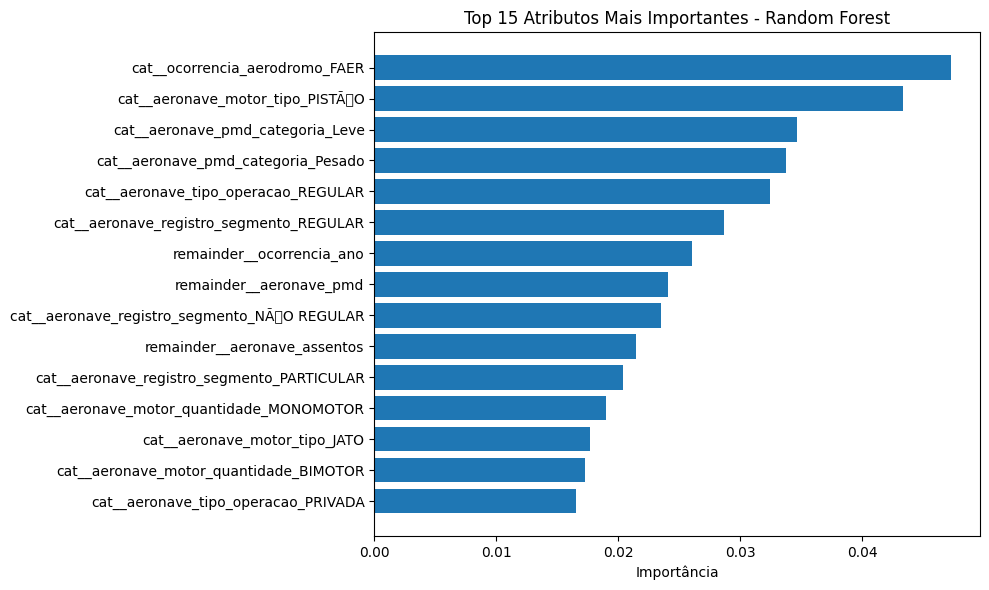

In [7]:
# Extrai as features após preprocessamento
feature_names = pipeline.named_steps['preprocessador'].get_feature_names_out()

# Importância das features
importances = pipeline.named_steps['classificador'].feature_importances_

# DataFrame ordenado
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(15)

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Top 15 Atributos Mais Importantes - Random Forest")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

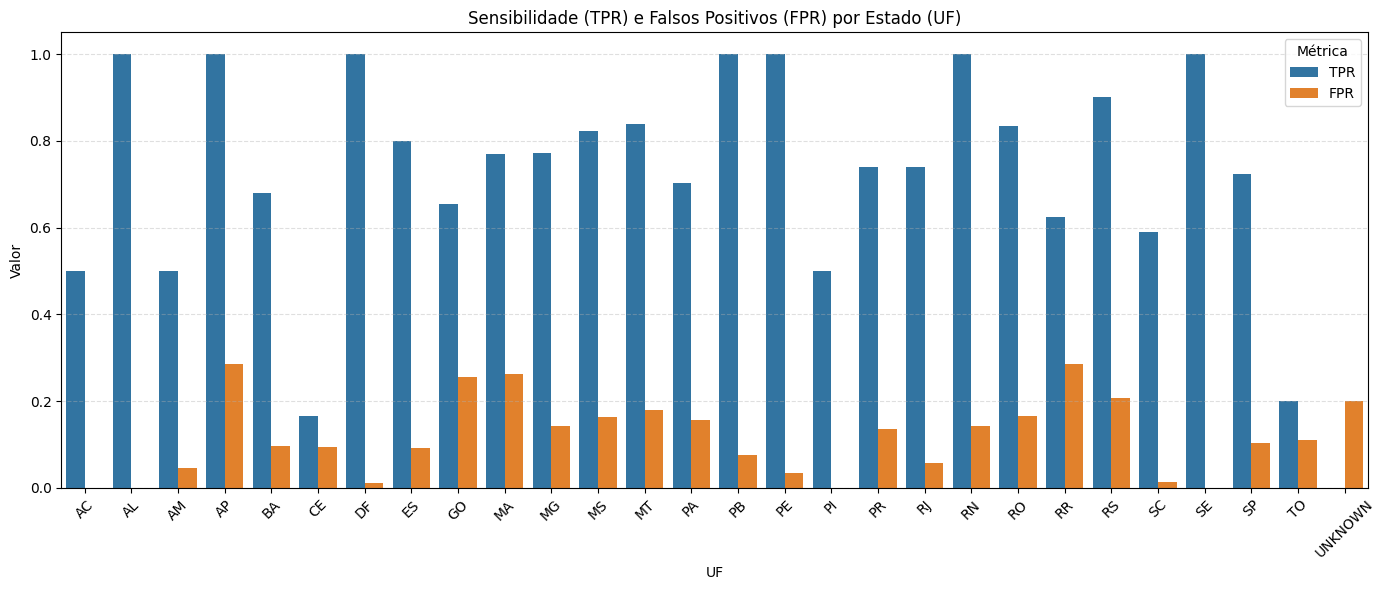

In [15]:
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate
from sklearn.preprocessing import LabelBinarizer

# Binariza target: 1 se for ACIDENTE, 0 caso contrário
y_true_bin = (y_test == "ACIDENTE").astype(int)
y_pred_bin = (y_pred == "ACIDENTE").astype(int)

# UF como grupo sensível
group = X_test['ocorrencia_uf']

# Métricas por grupo
mf = MetricFrame(
    metrics={
        'TPR (Sensibilidade)': true_positive_rate,
        'FPR (Falsos Positivos)': false_positive_rate
    },
    y_true=y_true_bin,
    y_pred=y_pred_bin,
    sensitive_features=group
)

# Converter para DataFrame e ajustar os nomes
df_fairness = mf.by_group.reset_index().rename(columns={
    'TPR (Sensibilidade)': 'TPR',
    'FPR (Falsos Positivos)': 'FPR',
    'ocorrencia_uf': 'UF'
})

# Transformar de wide para long (melt) para facilitar o plot
df_melted = df_fairness.melt(id_vars='UF', value_vars=['TPR', 'FPR'], var_name='Métrica', value_name='Valor')

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df_melted, x='UF', y='Valor', hue='Métrica')

plt.title("Sensibilidade (TPR) e Falsos Positivos (FPR) por Estado (UF)")
plt.ylabel("Valor")
plt.xlabel("UF")
plt.xticks(rotation=45)
plt.legend(title="Métrica")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

100%|===================| 31527/31560 [03:58<00:00]        /home/thiagopc757/programs/INF1032/env/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/thiagopc757/programs/INF1032/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


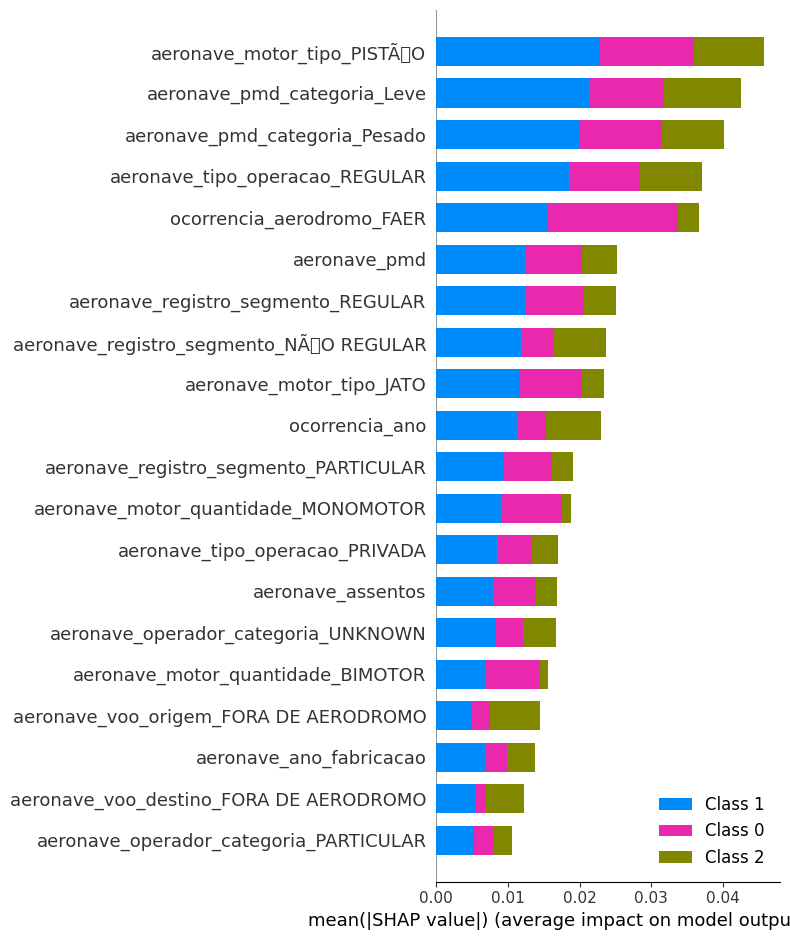

['ACIDENTE' 'INCIDENTE' 'INCIDENTE GRAVE']


In [27]:
X_train_transformed = pipeline.named_steps['preprocessador'].transform(X_train)

# Se for sparse, converte para array NumPy
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()
modelo_treinado = pipeline.named_steps['classificador']
# Extrair nomes das features transformadas
categorical_features = pipeline.named_steps['preprocessador'].transformers_[0][2]
encoder = pipeline.named_steps['preprocessador'].named_transformers_['cat']
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

# Juntar com as colunas numéricas
numerical_features = pipeline.named_steps['preprocessador'].transformers_[1][2]
all_feature_names = list(encoded_feature_names) + list(numerical_features)
explainer = shap.Explainer(modelo_treinado, X_train_transformed)
shap_values = explainer(X_train_transformed)
shap.summary_plot(shap_values, X_train_transformed, feature_names=all_feature_names)
print(pipeline.classes_)

No desenvolvimento deste modelo preditivo, foram incorporados princípios de ética e justiça algorítmica conforme discutido nos materiais da Aula 22. Utilizou-se a biblioteca Fairlearn para realizar uma análise de fairness, com foco na variável `ocorrencia_uf` como grupo sensível, a fim de investigar possíveis desigualdades no desempenho do modelo entre diferentes estados brasileiros. Métricas como True Positive Rate (TPR) e False Positive Rate (FPR) foram analisadas por grupo, permitindo identificar variações significativas que poderiam indicar viés algorítmico. Além disso, foram aplicadas técnicas de explicabilidade utilizando o método SHAP (SHapley Additive exPlanations), possibilitando compreender a contribuição de cada variável para as decisões do modelo, tanto em nível global quanto local. Essas práticas contribuem para garantir maior transparência, interpretabilidade e responsabilidade no uso de modelos de aprendizado de máquina em contextos sensíveis, como a análise de ocorrências aeronáuticas.